# Base Loading

## Package

In [2]:
import pandas as pd
import numpy as np
import os
import sklearn
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
#plt.style.use("ggplot")
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
plt.rcParams['font.family'] = 'Noto Sans CJK TC'
plt.rcParams['axes.unicode_minus']=False
plt.rcParams['axes.facecolor'] = "#FFFDF9"

## Data

In [10]:
data_107 = pd.read_csv("道路交通事故原因傷亡統計 107.csv", dtype='unicode')
data_108 = pd.read_csv("道路交通事故原因傷亡統計 108.csv", dtype='unicode')
data_109 = pd.read_csv("道路交通事故原因傷亡統計 109.csv", dtype='unicode')
data_110 = pd.read_csv("道路交通事故原因傷亡統計 110.csv", dtype='unicode')

# data 處理

In [11]:
# 移除 「2-30日內死亡人數」 變數
del data_107["光線"]
del data_109[" 2-30日內死亡人數"]
#del data_110["2-30日內死亡人數"]

In [12]:
# 統一命名
col_name = ['案件編號', '發生日期', '發生時間', 'GPS經度', 'GPS緯度', '案件類別', '地址類型', '發生地點',
            '24小時內死亡人數', '受傷人數', '天候', '速限-第1當事者', '道路型態', '事故位置', 
            '號誌種類', '事故類型及型態', '肇因研判']

data_107.columns = col_name
data_108.columns = col_name
data_109.columns = col_name
data_110.columns = col_name

In [13]:
#合併資料
data = pd.concat([data_107, data_108, data_109, data_110])
data = data.reset_index(drop=True)

data.shape

(159407, 17)

# 修正 type

In [33]:
data['GPS經度'] = data['GPS經度'].astype('float')
data['GPS緯度'] = data['GPS緯度'].astype('float')
data['24小時內死亡人數'] = data['24小時內死亡人數'].astype('int')
data['受傷人數'] = data['受傷人數'].astype('int')
data['速限-第1當事者'] = data['速限-第1當事者'].astype('int')

# 新增欄位

In [239]:
# 新增「區域」欄位
district = []
for col in range(data.shape[0]):
    start = data['發生地點'][col].find("市") + 1
    end   = data['發生地點'][col].find("區") + 1
    district.append(data['發生地點'][col][start:end])

data['區域'] = district

In [240]:
# 新增「季節」欄位
season = []
for col in range(data.shape[0]):
    month = int(data['發生日期'][col][4:6])
    
    if (month >= 3) & (month < 6):
        season.append("春天")
    elif (month >= 6) & (month < 9):
        season.append("夏天")
    elif (month >= 9) & (month < 12):
        season.append("秋天")
    else:
        season.append("冬天")

data['季節'] = season

In [10]:
# 議員選區
area = list(data['區域'])
area = ['第一選區' if x in ['新營區', '鹽水區', '柳營區', '後壁區', '白河區', '東山區'] else x for x in area]
area = ['第二選區' if x in ['佳里區', '七股區', '西港區', '北門區', '學甲區', '將軍區'] else x for x in area ]
area = ['第三選區' if x in ['麻豆區', '六甲區', '下營區', '官田區', '大內區'] else x for x in area ]
area = ['第四選區' if x in ['玉井區', '南化區', '楠西區', '左鎮區'] else x for x in area ]
area = ['第五選區' if x in ['安南區'] else x for x in area ]
area = ['第六選區' if x in ['善化區', '安定區', '山上區', '新化區', '新市區'] else x for x in area ]
area = ['第七選區' if x in ['永康區'] else x for x in area ]
area = ['第八選區' if x in ['北區', '中西區'] else x for x in area ]
area = ['第九選區' if x in ['安平區', '南區'] else x for x in area ]
area = ['第十選區' if x in ['東區'] else x for x in area ]
area = ['第十一選區' if x in ['仁德區', '歸仁區', '關廟區', '龍崎區'] else x for x in area]

data['議員選區'] = area

## 0515 路段再整理

In [2]:
# load data
data = pd.read_csv("道路交通事故原因傷亡統計107-110_有路燈.csv", dtype='unicode')

In [113]:
data.head(2)

,案件編號,發生日期,發生時間,GPS經度,GPS緯度,案件類別,地址類型,發生地點,24小時內死亡人數,受傷人數,...,事故位置,號誌種類,事故類型及型態,肇因研判,區域,季節,路燈數量,道路型態_大類別,路名或街名,里
0,10701AC191A0013,20180119,6-9時,120.2212,22.963416,交通事故,一般地址,臺南市東區生產路68號,1,0,...,機車優先道,無號誌,撞護欄(樁),未注意車前狀態,東區,冬天,0,直路,生產路,仁和里
1,10701AC191B0003,20180101,0-3時,120.235561,22.987356,交通事故,交叉路口,臺南市東區富農街二段西側與富農街二段12巷處,0,1,...,交叉路口內,無號誌,側撞,酒醉(後)駕駛失控,東區,冬天,1,交岔路,富農街,東聖里


In [306]:
def number_replace(string):
    find_number = re.search('[0-9]+', string)
    if find_number:
        number = find_number.group()
        if len(number) > 2:
            string = string[:find_number.span()[0]]
        
        else:
            number = number.replace('1', '一')
            number = number.replace('2', '二')
            number = number.replace('3', '三')
            number = number.replace('4', '四')
            number = number.replace('5', '五')
            number = number.replace('6', '六')
            number = number.replace('7', '七')
            number = number.replace('8', '八')
            number = number.replace('9', '九')
            number = number.replace('0', '十')

            if (len(number) == 2) and (number[0] == '一'):
                number = '十'+number[1]
                
            if (len(number) == 2) and (number.find('十')==-1):
                number = number[0] + '十' + number[1]

            string = string.replace(find_number.group(), number)

    return string

In [307]:
import re

# 「發生地點」欄位
spot_string = list(data['路名或街名'])
address = list(data['發生地點'])

for col in range(data.shape[0]):#
    Q = ''
    s_ls = ["段號0", "*", ".", "(", ")"]
    for x in s_ls:
        address[col] = address[col].replace(x, "")

        
    # 統一"台"字        
    address[col] = address[col].replace("臺", "台")
    # 修正錯誤
    address[col] = address[col].replace("佳里區", "佳區")
    address[col] = address[col].replace("里里", "里")
    address[col] = address[col].replace("公里", "")
    address[col] = address[col].replace("後街里", "後里")
    address[col] = address[col].replace("ㄧ", "一")

    address[col] = address[col].replace("大橋", "橋")
    address[col] = address[col].replace("陸橋", "橋")
    address[col] = address[col].replace("甲線", "線")
    address[col] = address[col].replace("乙線", "線")
    address[col] = address[col].replace("河堤便路", "河堤道路")
    address[col] = address[col].replace("無名道路", "未命名道路")

        
    s_ls = ["區段口巷弄號", "路段口巷弄號", "路口巷弄號", "區段號", "路段號", "段段號", "街段口", "區巷弄號", "里巷弄號"]
    for x in s_ls:
        s1 = address[col].find(x) + 1
        if s1 != 0:
            address[col] = address[col].replace(address[col][s1:s1+len(x)-1], "")
    
    s_ls = ["區段", "路段", "路口", "街口", '里區', "線路", '線段', "旁路", "段段"]
    for x in s_ls:
        s1 = address[col].find(x) + 1
        if s1 != 0:
            address[col] = address[col][:s1] + address[col][s1+1:]

    # 特殊路名
    special = False
    special_ls = ['四草大道', '鹿耳門大道', '台江大道', '蘭科大道', '西拉雅大道', '新港社大道', '樹谷大道', 
                  '民生綠園', '西港大橋', '台南都會區北外環道路', '鐵線橋', '三村一街', '三村二街'
                  '中山高速公路', '南二高速公路', '未命名道路', 

                  '台86', '台一線', '後甲國中旁便道', '後甲國中便道', 
                  '湯德章公園', '歸仁圓環', '西門圓環', '火車站圓環', '後甲圓環', '新化圓環',
                  '東門城圓環', '東門路圓環', '東門圓環', '歸仁圓環', '南門圓環', '北門圓環', 
                  '國姓橋', '觀海橋', '大成陸橋', '中洲橋', '頂寮橋', '溪頂寮橋', '永康橋', '目加溜灣大道',
                  '奇美橋', '大洲一號橋', '大洲二號橋', '大洲三號橋', '大洲四號橋', '新灣橋', '真理橋', '直加弄大道',
                  '大洲1號橋', '大洲2號橋', '大洲3號橋', '大洲4號橋', '陽光大道',
                  '日光橋', '林鳳營橋', '安順橋', '西港橋', '二層行橋', '中正橋', '豐化橋', '麻善橋', '四草大橋', 
                  '永安橋', '南萣橋', '民族橋', '溪頂寮大橋', '保西橋', '光文橋', '網寮橋', '北安橋', '華宗橋', 
                  '水景橋', '漁光橋', '下甲橋', '鐵線橋', '安億橋', '航太橋', '安順橋', '鹽水溪橋', '中華橋', 
                  '三爺宮溪', '九份子大道', "河堤道路"
                 ]
    for x in special_ls:
        if address[col].find(x) != -1: 
            Q = x
            special = True
            break

    # 省道、縣道、市道、區道
    if not special: 
        special_ls = [r'台[0-9]+線', r'[0-9]+線']
        for x in special_ls:
            result = re.search(x, address[col])
            if result:
                Q = result.group()
                special = True
                break   

    if not special:  
        result = re.search(r'南[0-9]+在', address[col])
        if result:
            Q = result.group()[:-1]
            special = True

    # 路名、街名
    if not special:
        and_ = address[col].find("與")
        if and_ != -1: # 有兩條以上的道路取前面的那條
            address[col] = address[col][:and_]

        # 兩條路
        double_road = [
            r'里[0-9\u4E00-\u9FA5]+路[0-9\u4E00-\u9FA5]+路', 
            r'區[0-9\u4E00-\u9FA5]+路[0-9\u4E00-\u9FA5]+路',
            r'里[0-9\u4E00-\u9FA5]+街[0-9\u4E00-\u9FA5]+街', 
            r'區[0-9\u4E00-\u9FA5]+街[0-9\u4E00-\u9FA5]+街', 
            r'里[0-9\u4E00-\u9FA5]+街[0-9\u4E00-\u9FA5]+路', 
            r'區[0-9\u4E00-\u9FA5]+街[0-9\u4E00-\u9FA5]+路', 
            r'里[0-9\u4E00-\u9FA5]+路[0-9\u4E00-\u9FA5]+街', 
            r'區[0-9\u4E00-\u9FA5]+路[0-9\u4E00-\u9FA5]+街', 
        ]
        # 單條路
        single_road = [
            r'里[\u4E00-\u9FA5]+路[0-9\u4E00-\u9FA5]+段', 
            r'區[\u4E00-\u9FA5]+路[0-9\u4E00-\u9FA5]+段',
            r'里[\u4E00-\u9FA5]+路', r'區[\u4E00-\u9FA5]+路',
            r'里[\u4E00-\u9FA5]+街[0-9\u4E00-\u9FA5]+段',
            r'區[\u4E00-\u9FA5]+街[0-9\u4E00-\u9FA5]+段',
            r'里[0-9\u4E00-\u9FA5]+街', r'區[0-9\u4E00-\u9FA5]+街', 
        ]

        for x in double_road:
            result = re.search(x, address[col])
            if result:
                address[col] = result.group()[:-1]
                break

        for x in single_road:
            result = re.search(x, address[col])
            if result:
                Q = result.group()[1:]
                Q = number_replace(Q)
                break

    # 大於七字的不正常 或是 上面通通沒找到
    if (len(Q) > 7) or (Q ==""):
        Q = "非具體路段"
        
        # 沒有路名的地方
        special_ls = ['路燈', '燈桿', '電桿']
        for x in special_ls:        
            if address[col].find(x) != -1: 
                Q = "未命名道路"
                break

    if Q.find("、") != 0:
        Q = Q[Q.find("、")+1:]

    spot_string[col] = Q

#data['路名或街名'] = spot

In [311]:
data['路名或街名'] = spot_string
# 儲存資料
# data.to_csv("道路交通事故原因傷亡統計107-110_有路燈.csv", index=False, encoding='utf_8_sig')

# 合併欄位資料

## 道路型態
道路型態原有19項，整理合併為7項:  
1.「直路」  
2.「交岔路」:包含交岔路、三岔路、四岔路、多岔路  
3.「單路部分」包含單路部分  
4.「圓環」:包含圓環、圓環廣場  
5.「彎曲路及附近」  
6.「平交道」  
7.「其他」:包含其他、橋樑、巷弄、坡路、地下道、高架道路、涵洞、廣場、有遮斷器  

In [57]:
road_type = list(data['道路型態'])
road_type = ['交岔路' if x in ['交岔路', '三岔路', '四岔路', '多岔路'] else x for x in road_type]
road_type = ['圓環' if x in ['圓環', '圓環廣場'] else x for x in road_type ]
road_type = ['其他' if x in ['其他', '橋樑', '巷弄', '坡路', '地下道', '高架道路', '涵洞', '廣場', '有遮斷器'] else x for x in road_type]
data['道路型態_大類別'] = road_type

## 發生時間

In [23]:
# 修正「發生時間」欄位
time_string = list(data['發生時間'])
time_string = ["{:0>6s}".format(x) for x in time_string]  # 在前面補消失的 0
time_string = [int(x[:2]) for x in time_string]  # 取"小時"，轉數字

# 將時間切成 8 等分， 0-3時. 3-6時. 6-9時. 9-12時. 12-15時. 15-18時. 18-21時. 21-24時
time = []
for col in range(data.shape[0]):
    t = time_string[col]
    
    if (t >= 0) & (t < 3):
        time.append("0-3時")
    elif (t >= 3) & (t < 6):
        time.append("3-6時")
    elif (t >= 6) & (t < 9):
        time.append("6-9時")
    elif (t >= 9) & (t < 12):
        time.append("9-12時")
    elif (t >= 12) & (t < 15):
        time.append("12-15時")
    elif (t >= 15) & (t < 18):
        time.append("15-18時")
    elif (t >= 18) & (t < 21):
        time.append("18-21時")
    elif (t >= 21) & (t < 24):
        time.append("21-24時")

data['發生時間'] = time

# 減量版資料 - 只有地址

In [7]:
# load data
data = pd.read_csv("事故傷亡統計_合併-2_107_110.csv", dtype='unicode')

In [9]:
data_reduced = data[['年', '月', '日', "發生時間", "發生地點", "行政區", '里', "路名或街名", "GPS經度", "GPS緯度"]]
data_reduced.head(1)

# 儲存資料
data_reduced.to_csv("事故傷亡統計_只有地址.csv", index=False, encoding='utf_8_sig')

# 新資料! 當事者資料

In [135]:
# load data
whole = pd.read_csv("事故傷亡統計.csv", dtype='unicode')
data = pd.read_csv("事故傷亡統計_當事者資料.csv", dtype='unicode')

data = data[['案件編號', '年', '月', '當事者順位', '國籍', '當事者屬性別名稱', '當事者事故發生時年齡', 
             '當事者區分類別大類別名稱-車種', '當事者區分類別子類別名稱-車種', '牌照種類名稱', 
             '受傷程度名稱', '主要傷處名稱', '保護裝備名稱']].set_index('案件編號')
data[['受傷程度名稱', '主要傷處名稱', '保護裝備名稱']] = data[['受傷程度名稱', '主要傷處名稱', '保護裝備名稱']].replace(' ', '不明')

whole = whole[['案件編號', '發生時間', "區域", '議員選區', '道路型態', '號誌種類', '路燈數量', 
               '事故位置', '事故類型及型態', '肇因研判']].set_index('案件編號')

In [103]:
print(data.shape, whole.shape)

(266372, 12) (159407, 8)


In [136]:
df2 = data.merge(whole, how='left', left_index=True, right_index=True)
df2 = df2.reset_index()
df2[['發生時間', '議員選區', '道路型態', '號誌種類', '事故位置', '事故類型及型態', '肇因研判']] = df2[['發生時間', '議員選區', '道路型態', '號誌種類', '事故位置', '事故類型及型態', '肇因研判']].fillna(value='未登記')
df2[["區域"]] = df2[["區域"]].fillna(value='未登記')
df2[['路燈數量']] = df2[['路燈數量']].fillna(value=-1)
df2[['牌照種類名稱']] = df2[['牌照種類名稱']].replace(' ', '無')
df2[['國籍']] = df2[['國籍']].replace(' ', '-1')
df2[['當事者屬性別名稱']] = df2[['當事者屬性別名稱']].replace(' ', '未登記')

df2.head(1)

,案件編號,年,月,當事者順位,國籍,當事者屬性別名稱,當事者事故發生時年齡,當事者區分類別大類別名稱-車種,當事者區分類別子類別名稱-車種,牌照種類名稱,...,保護裝備名稱,發生時間,區域,議員選區,道路型態,號誌種類,路燈數量,事故位置,事故類型及型態,肇因研判
0,10801AC191A0011,108,1,1,1,男,25,小客車,自用,汽車,...,戴安全帽或繫安全帶(使用幼童安全椅),3-6時,東區,第十選區,交岔路,行車管制號誌,0,交岔路口,車與車,違反號誌管制或指揮


In [137]:
df2 = df2[df2['當事者屬性別名稱'].isin(['男', '女'])].reset_index(drop=True)
#df2.to_csv("當事者資料_全.csv", index=False, encoding='utf_8_sig')

In [107]:
df2 = df2[df2['受傷程度名稱'].isin(['24小時內死亡', '2-30日內死亡'])].reset_index(drop=True)
#df2.to_csv("當事者資料_死亡.csv", index=False, encoding='utf_8_sig')

In [108]:
df2.shape

(772, 21)

## 人單位資料繪圖

In [161]:
df2 = pd.read_csv("當事者資料_全.csv", dtype='unicode')

In [174]:
sns.color_palette()[1:4]

[(0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)]

Text(0, 0.5, '死亡車禍人數')

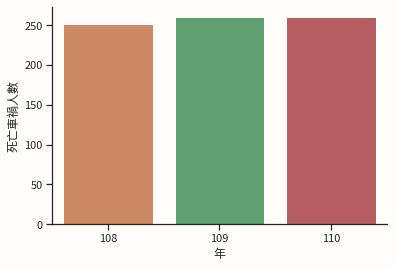

In [175]:
b = df2[df2['受傷程度名稱'].isin(['24小時內死亡', '2-30日內死亡'])]

plt.figure(figsize=(6, 4), facecolor='#FFFDF9')
sns.countplot(data=b, x='年', palette=sns.color_palette()[1:4])

plt.ylabel('死亡車禍人數')

Text(0, 0.5, '人數')

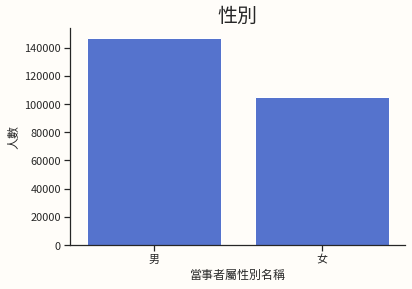

In [43]:
s = '當事者屬性別名稱'
plt.figure(figsize=(6, 4), facecolor='#FFFDF9')
sns.countplot(x=s, data=df2, color='royalblue') 
plt.title("性別", fontsize=20)
plt.ylabel('人數')

Text(0, 0.5, '人數')

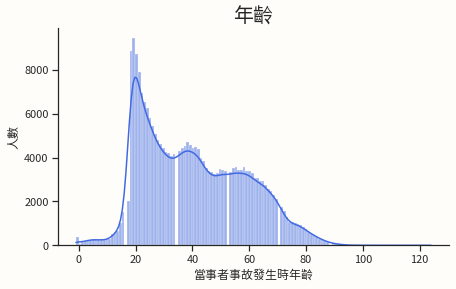

In [44]:
df2['當事者事故發生時年齡'] = df2['當事者事故發生時年齡'].astype('int')

s = '當事者事故發生時年齡'
plt.figure(figsize=(7, 4), facecolor='#FFFDF9')
ax = sns.histplot(x=s, data=df2, color='royalblue', kde=True) 
plt.title("年齡", fontsize=20)
plt.ylabel('人數')

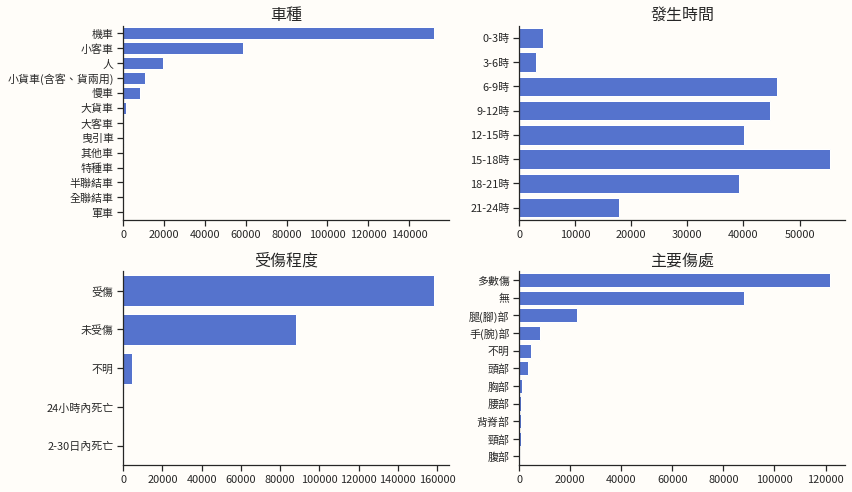

In [45]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 7), facecolor='#FFFDF9')

fontsize = 16
sns.barplot(x=list(df2['當事者區分類別大類別名稱-車種'].value_counts()), 
            y=list(df2['當事者區分類別大類別名稱-車種'].value_counts().index), 
            color='royalblue', orient='h', ax=axes[0][0]) 
axes[0][0].set_title("車種", fontsize=fontsize)

sns.barplot(x=list(df2['發生時間'].value_counts()), 
            y=list(df2['發生時間'].value_counts().index), 
            order=['0-3時', '3-6時', '6-9時', '9-12時', '12-15時', '15-18時', '18-21時', '21-24時'],
            color='royalblue', orient='h', ax=axes[0][1]) 
axes[0][1].set_title("發生時間", fontsize=fontsize)

sns.barplot(x=list(df2['受傷程度名稱'].value_counts()), 
            y=list(df2['受傷程度名稱'].value_counts().index), 
            color='royalblue', orient='h', ax=axes[1][0]) 
axes[1][0].set_title("受傷程度", fontsize=fontsize)

sns.barplot(x=list(df2['主要傷處名稱'].value_counts()), 
            y=list(df2['主要傷處名稱'].value_counts().index), 
            color='royalblue', orient='h', ax=axes[1][1]) 
axes[1][1].set_title("主要傷處", fontsize=fontsize)

fig.tight_layout()

In [46]:
car_type = list(df2['當事者區分類別大類別名稱-車種'])
car_type = ['人、慢車' if x in ['人', '慢車'] else x for x in car_type]
car_type = ['小客車、小貨車' if x in ['小客車', '小貨車(含客、貨兩用)'] else x for x in car_type]
car_type = ['大型車' if x in ['大貨車', '大客車', '半聯結車', '曳引車', '全聯結車'] else x for x in car_type]
car_type = ['其他車' if x in ['特種車', '軍車', '其他車'] else x for x in car_type]
a = pd.DataFrame({"受傷程度名稱":df2['受傷程度名稱'], '車種':car_type})

Text(0, 0.5, '人數')

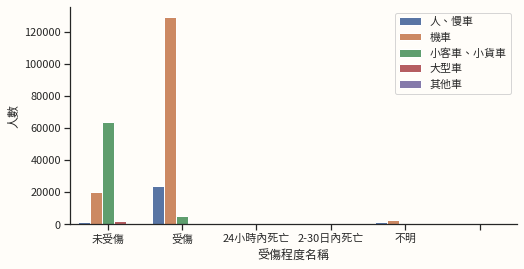

In [47]:
plt.figure(figsize=(8, 4), facecolor='#FFFDF9')
sns.countplot(x='受傷程度名稱', data=a, order=['未受傷', '受傷', '24小時內死亡', '2-30日內死亡', '不明', ''], 
              hue='車種', hue_order=['人、慢車', '機車', '小客車、小貨車', '大型車', '其他車']) 
plt.legend(loc='upper right') 
plt.ylabel('人數')

Text(0, 0.5, '人數')

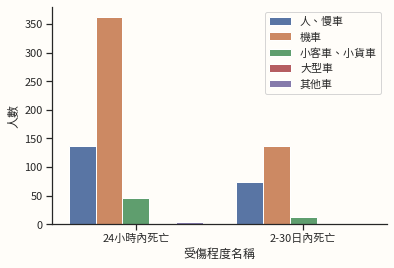

In [48]:
b = a[a['受傷程度名稱'].isin(['24小時內死亡', '2-30日內死亡'])]
plt.figure(figsize=(6, 4), facecolor='#FFFDF9')
sns.countplot(x='受傷程度名稱', data=b, hue='車種', 
              hue_order=['人、慢車', '機車', '小客車、小貨車', '大型車', '其他車']) 
plt.legend(loc='upper right') 
plt.ylabel('人數')

## 車禍單位資料繪圖 - 全

In [152]:
df2 = pd.read_csv("事故傷亡統計.csv", dtype='unicode')

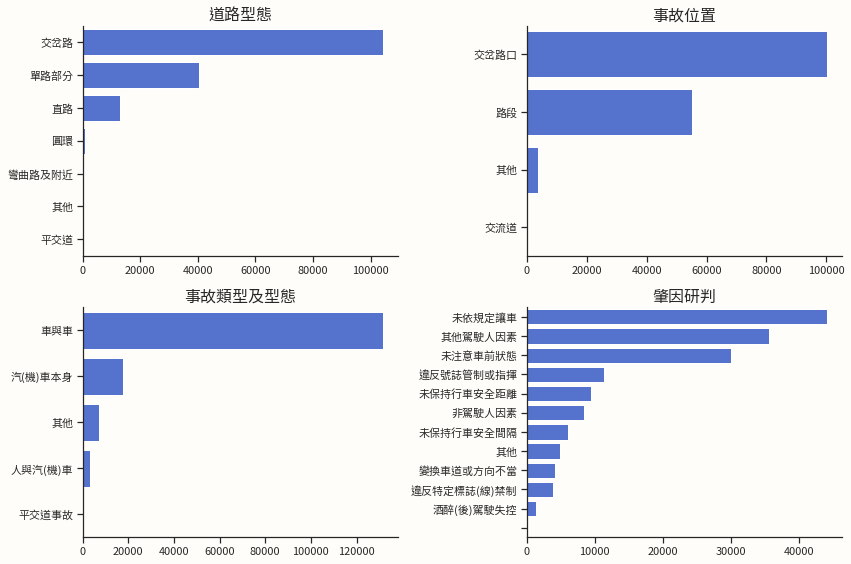

In [54]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8), facecolor='#FFFDF9')

fontsize = 16
sns.barplot(x=list(df2['道路型態'].value_counts()), 
            y=list(df2['道路型態'].value_counts().index), 
            color='royalblue', orient='h', ax=axes[0][0]) 
axes[0][0].set_title("道路型態", fontsize=fontsize)

sns.barplot(x=list(df2['事故位置'].value_counts()), 
            y=list(df2['事故位置'].value_counts().index), 
            color='royalblue', orient='h', ax=axes[0][1]) 
axes[0][1].set_title("事故位置", fontsize=fontsize)

sns.barplot(x=list(df2['事故類型及型態'].value_counts()), 
            y=list(df2['事故類型及型態'].value_counts().index), 
            color='royalblue', orient='h', ax=axes[1][0]) 
axes[1][0].set_title("事故類型及型態", fontsize=fontsize)

sns.barplot(x=list(df2['肇因研判'].value_counts()), 
            y=list(df2['肇因研判'].value_counts().index), 
            color='royalblue', orient='h', ax=axes[1][1]) 
axes[1][1].set_title("肇因研判", fontsize=fontsize)

fig.tight_layout()

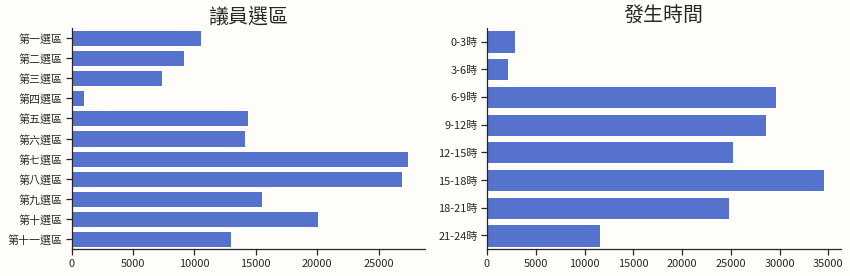

In [55]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4), facecolor='#FFFDF9')

fontsize = 20
sns.barplot(x=list(df2['議員選區'].value_counts()), 
            y=list(df2['議員選區'].value_counts().index), 
            order=['第一選區', '第二選區', '第三選區', '第四選區', '第五選區', '第六選區', 
                   '第七選區', '第八選區', '第九選區', '第十選區', '第十一選區'],
            color='royalblue', orient='h', ax=axes[0]) 
axes[0].set_title("議員選區", fontsize=fontsize)

sns.barplot(x=list(df2['發生時間'].value_counts()), 
            y=list(df2['發生時間'].value_counts().index), 
            order=['0-3時', '3-6時', '6-9時', '9-12時', '12-15時', '15-18時', '18-21時', '21-24時'],
            color='royalblue', orient='h', ax=axes[1]) 
axes[1].set_title("發生時間", fontsize=fontsize)

fig.tight_layout()

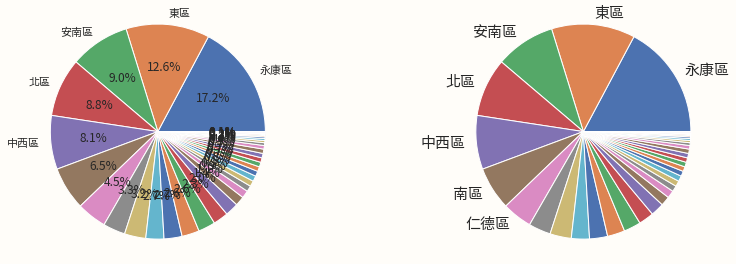

In [59]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4), facecolor='#FFFDF9')

fontsize = 20
axes[0].pie(list(df2["區域"].value_counts()),
            radius=1.5,
            labels=list(df2["區域"].value_counts().index)[:5] + [" "]*32,
            autopct='%.1f%%', # %.1f%% 表示顯示小數點一位的浮點數，後方加上百分比符號
            )   
#axes[0].set_title("議員選區", fontsize=fontsize)

axes[1].pie(list(df2["區域"].value_counts()),
            radius=1.5,
            labels=list(df2["區域"].value_counts().index)[:7] + [" "]*30,
            textprops = {"fontsize" : 15},
            )
#axes[1].set_title("議員選區", fontsize=fontsize)

fig.tight_layout()

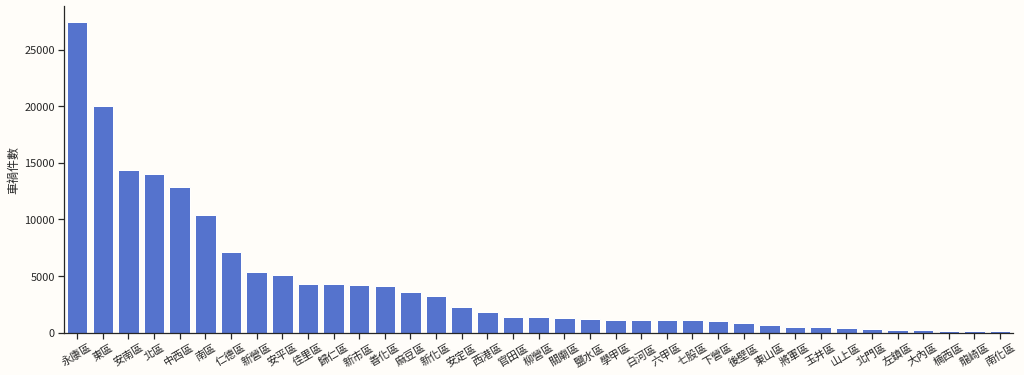

In [61]:
x = '區域'
plt.figure(figsize=(17, 6), facecolor='#FFFDF9')
sns.barplot(x=list(df2[x].value_counts().index), 
            y=list(df2[x].value_counts()), 
            color='royalblue')
plt.xticks(rotation=30)
plt.ylabel('車禍件數')
plt.show()

## 車禍單位資料繪圖 - 死亡車禍

In [153]:
df = df2[df2['24小時內死亡人數']!='0']

Text(0, 0.5, '死亡車禍件數')

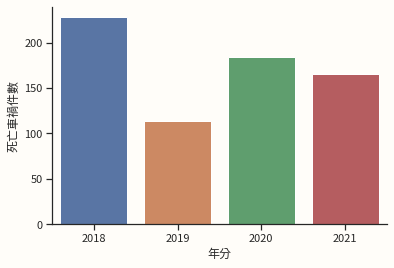

In [158]:
plt.figure(figsize=(6, 4), facecolor='#FFFDF9')
sns.countplot(data=df, x='年分')
plt.ylabel('死亡車禍件數')

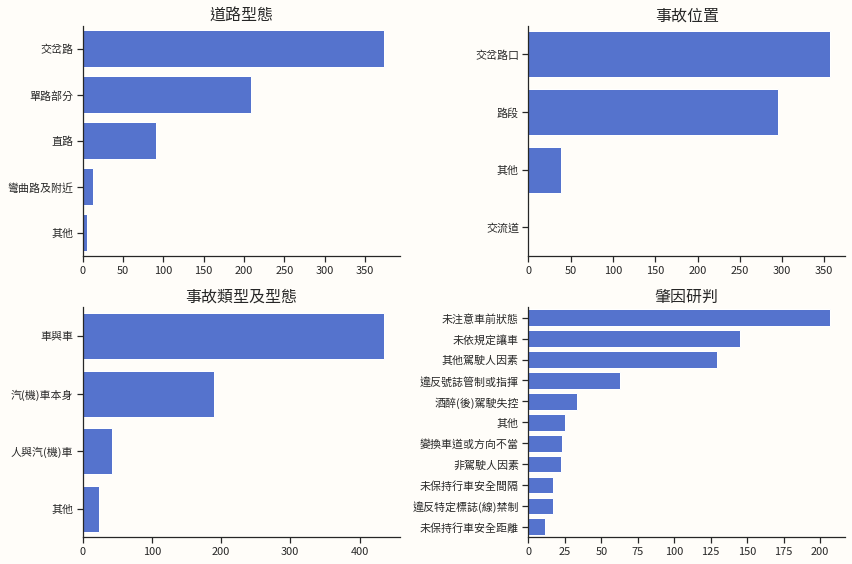

In [71]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8), facecolor='#FFFDF9')

fontsize = 16
sns.barplot(x=list(df['道路型態'].value_counts()), 
            y=list(df['道路型態'].value_counts().index), 
            color='royalblue', orient='h', ax=axes[0][0]) 
axes[0][0].set_title("道路型態", fontsize=fontsize)

sns.barplot(x=list(df['事故位置'].value_counts()), 
            y=list(df['事故位置'].value_counts().index), 
            color='royalblue', orient='h', ax=axes[0][1]) 
axes[0][1].set_title("事故位置", fontsize=fontsize)

sns.barplot(x=list(df['事故類型及型態'].value_counts()), 
            y=list(df['事故類型及型態'].value_counts().index), 
            color='royalblue', orient='h', ax=axes[1][0]) 
axes[1][0].set_title("事故類型及型態", fontsize=fontsize)

sns.barplot(x=list(df['肇因研判'].value_counts()), 
            y=list(df['肇因研判'].value_counts().index), 
            color='royalblue', orient='h', ax=axes[1][1]) 
axes[1][1].set_title("肇因研判", fontsize=fontsize)

fig.tight_layout()

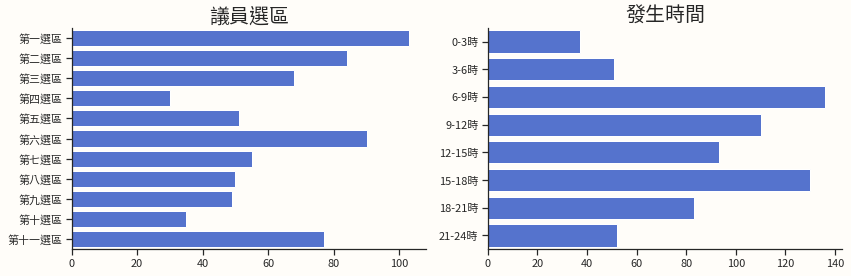

In [69]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4), facecolor='#FFFDF9')

fontsize = 20
sns.barplot(x=list(df['議員選區'].value_counts()), 
            y=list(df['議員選區'].value_counts().index), 
            order=['第一選區', '第二選區', '第三選區', '第四選區', '第五選區', '第六選區', 
                   '第七選區', '第八選區', '第九選區', '第十選區', '第十一選區'],
            color='royalblue', orient='h', ax=axes[0]) 
axes[0].set_title("議員選區", fontsize=fontsize)

sns.barplot(x=list(df['發生時間'].value_counts()), 
            y=list(df['發生時間'].value_counts().index), 
            order=['0-3時', '3-6時', '6-9時', '9-12時', '12-15時', '15-18時', '18-21時', '21-24時'],
            color='royalblue', orient='h', ax=axes[1]) 
axes[1].set_title("發生時間", fontsize=fontsize)

fig.tight_layout()

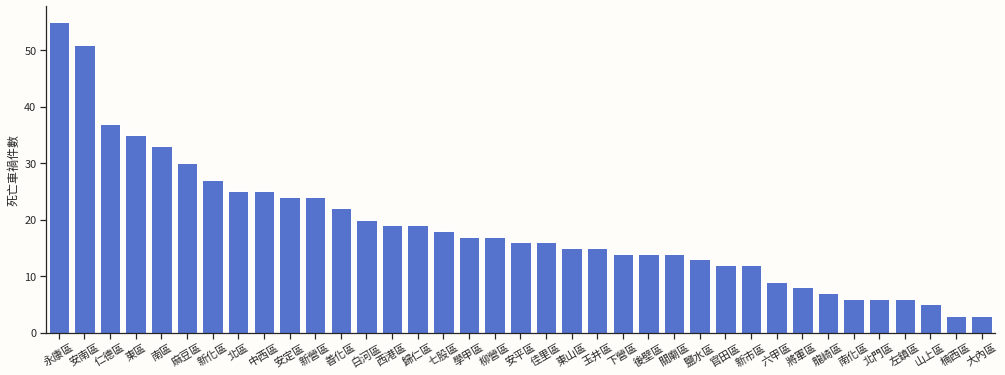

In [70]:
x = '區域'
plt.figure(figsize=(17, 6), facecolor='#FFFDF9')
sns.barplot(x=list(df[x].value_counts().index), 
            y=list(df[x].value_counts()), 
            color='royalblue')
plt.xticks(rotation=30)
plt.ylabel('死亡車禍件數')
plt.show()

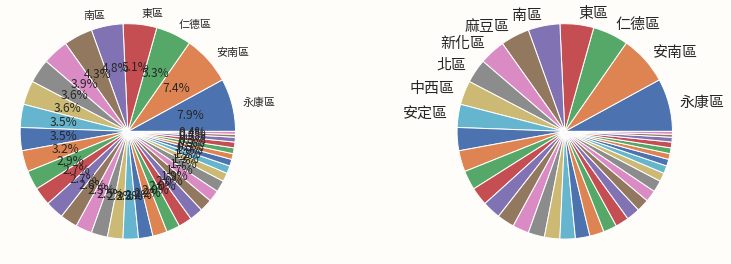

In [150]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4), facecolor='#FFFDF9')

fontsize = 20
axes[0].pie(list(df["區域"].value_counts()),
            radius=1.5,
            labels=list(df["區域"].value_counts().index)[:5] + [" "]*32,
            autopct='%.1f%%', # %.1f%% 表示顯示小數點一位的浮點數，後方加上百分比符號
            )   
#axes[0].set_title("議員選區", fontsize=fontsize)

axes[1].pie(list(df["區域"].value_counts()),
            radius=1.5,
            labels=list(df["區域"].value_counts().index)[:10] + [" "]*27,
            textprops = {"fontsize" : 15},
            )
#axes[1].set_title("議員選區", fontsize=fontsize)

fig.tight_layout()

## 分群

In [116]:
data = pd.read_csv("當事者資料_全.csv", dtype='unicode')
del data['案件編號']
del data['當事者區分類別子類別名稱-車種']
del data['牌照種類名稱']

In [117]:
from sklearn.preprocessing import LabelEncoder
data['路燈數量'] = data['路燈數量'].astype('int')
#對二元變數編碼
encoder = LabelEncoder()
data['當事者屬性別名稱'] = encoder.fit_transform(data['當事者屬性別名稱'])

#對多元變數編碼
multi_cols = [
    '當事者區分類別大類別名稱-車種', '受傷程度名稱', '主要傷處名稱', '保護裝備名稱', '發生時間', 
    '議員選區', '道路型態', '號誌種類', '事故位置', '事故類型及型態', '肇因研判'
]
data = pd.get_dummies(data = data, columns = multi_cols)

In [118]:
data.shape

(251670, 96)

In [119]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(data)

In [122]:
data['cluster'] = ['cluster2' if i==0 else 'cluster1' for i in kmeans.labels_]

In [123]:
data.to_csv("當事者資料_分群_1.csv", index=False, encoding='utf_8_sig')